# Previsão de Eleição de Deputados
### Aluno: Rayana Souza Rocha
[Link do do Github da atividade de Rayana](https://github.com/rayanarocha/machinelearning/blob/fdb4b3dcfb4a3878cc60be43717c383f5e0d1925/previs%C3%A3o-de-vota%C3%A7%C3%A3o-de-deputados/novo.ipynb)

### Arquivo submetido no Kaggle

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
from sklearn import preprocessing
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier
from statistics import mean
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [38]:
df = pd.read_csv('sample_submission.csv')
msk = np.random.rand(len(df)) < 0.8 # cria uma mascara com as posicoes
train = df[msk]
test = df[~msk]
print('\nFormato do dataset train:',train.shape, '\n')
print('\nFormato do dataset test:',test.shape, '\n')
train.head(3)


Formato do dataset train: (3683, 2) 


Formato do dataset test: (909, 2) 



,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,eleito
2,10000000158,nao_eleito


In [39]:
train.isnull().sum()

Id           0
Predicted    0
dtype: int64

In [40]:
test.isnull().sum()

Id           0
Predicted    0
dtype: int64

In [41]:
train

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,eleito
2,10000000158,nao_eleito
4,10000000163,nao_eleito
5,10000000164,eleito
...,...,...
4586,270000000303,nao_eleito
4588,270000000305,nao_eleito
4589,270000000312,eleito
4590,270000000329,nao_eleito


In [42]:
X_train = train.loc[:,'Id':'Predicted']
X_test = test.loc[:,'Id':'Predicted']
print('\nFormato do dataset X_train:',X_train.shape, '\n')
print('\nFormato do dataset X_test:',X_test.shape, '\n')
X_train.head(3)


Formato do dataset X_train: (3683, 2) 


Formato do dataset X_test: (909, 2) 



,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,eleito
2,10000000158,nao_eleito


In [43]:
train['Predicted'].value_counts()

nao_eleito    1861
eleito        1822
Name: Predicted, dtype: int64

In [44]:
y_train = pd.core.series.Series(train['Predicted']=='eleito', dtype='int64')
y_train

0       0
1       1
2       0
4       0
5       1
       ..
4586    0
4588    0
4589    1
4590    0
4591    1
Name: Predicted, Length: 3683, dtype: int64

In [45]:
numeric_features = list(X_train.dtypes[X_train.dtypes != "object"].index)
numeric_features

['Id']

In [46]:
X_train[numeric_features] = np.log1p(X_train[numeric_features])
X_test[numeric_features] = np.log1p(X_test[numeric_features])
X_train.head(3)

,Id,Predicted
0,23.025851,nao_eleito
1,23.025851,eleito
2,23.025851,nao_eleito


In [47]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train[numeric_features] = min_max_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = min_max_scaler.fit_transform(X_test[numeric_features])
X_train.head(3)

,Id,Predicted
0,0.000000e+00,nao_eleito
1,2.123883e-10,eleito
2,6.978489e-10,nao_eleito


In [48]:
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
categorical_features

['Predicted']

#### 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (10 pt.)

In [49]:
X_train['Predicted'].value_counts()

nao_eleito    1861
eleito        1822
Name: Predicted, dtype: int64

In [50]:
instancias_predicted = X_train['Predicted'].value_counts()
media_instancias_predicted = instancias_predicted.mean()
media_instancias_predicted

1841.5

In [51]:
std_instancias_por_partido = instancias_predicted.std()
std_instancias_por_partido

27.577164466275352

In [52]:
principais_partidos = list((instancias_predicted[ (instancias_predicted-media_instancias_predicted)>=-1.2*std_instancias_por_partido ]).index)
principais_partidos

['nao_eleito', 'eleito']

In [53]:
X_train.head(1)

,Id,Predicted
0,0.0,nao_eleito


In [54]:
X_test.head(1)

,Id,Predicted
3,0.0,eleito


In [55]:
def validacao_cruzada(modelo, x, y, oversampling=False):
    kfold = KFold(n_splits=5)
    acuracias_split = []

    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(x)):
        x_split_treino = x.iloc[idx_treino, :]
        y_split_treino = y.iloc[idx_treino, :]

        if oversampling:
            sm = SMOTE(random_state=42)
            x_split_treino, y_split_treino = sm.fit_resample(x_split_treino, y_split_treino)

        modelo.fit(x_split_treino, y_split_treino.values.flatten())

        x_split_validacao = x.iloc[idx_validacao, :]
        y_split_validacao = y.iloc[idx_validacao, :]

        predicoes_validacao = modelo.predict(x_split_validacao)

        acuracia_split = accuracy_score(y_split_validacao, predicoes_validacao)

        acuracias_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {acuracia_split}')

    return acuracias_split

In [56]:
onehotencode = OneHotEncoder(X_train[categorical_features], use_cat_names=True)
dummies = onehotencode.fit_transform(X_train[categorical_features])
lista_dummies = list(onehotencode.get_feature_names())
print('Total de variáveis dummy:', len(lista_dummies))
lista_dummies

Total de variáveis dummy: 2


['Predicted_nao_eleito', 'Predicted_eleito']

In [57]:
dummies = pd.DataFrame(dummies, columns = lista_dummies)
print(dummies.shape)
dummies.head(3)

(3683, 2)


,Predicted_nao_eleito,Predicted_eleito
0,1,0
1,0,1
2,1,0


In [58]:
X_train = pd.concat([X_train[numeric_features], dummies], axis=1)
print(X_train.shape)
X_train.head(3)

(3683, 3)


,Id,Predicted_nao_eleito,Predicted_eleito
0,0.000000e+00,1,0
1,2.123883e-10,0,1
2,6.978489e-10,1,0


In [59]:
X_test.shape

(909, 2)

In [60]:
dummies_test = onehotencode.transform(X_test[categorical_features])
dummies_test = pd.DataFrame(dummies_test, columns = lista_dummies)
print(dummies_test.shape)
dummies.head(3)

(909, 2)


,Predicted_nao_eleito,Predicted_eleito
0,1,0
1,0,1
2,1,0


In [61]:
X_test = pd.concat([X_test[numeric_features], dummies_test], axis=1)
print(X_test.shape)
X_test.head(3)

(909, 3)


,Id,Predicted_nao_eleito,Predicted_eleito
3,0.000000e+00,0,1
22,6.128944e-09,1,0
30,1.338052e-08,1,0


In [62]:
features = list(X_train.dtypes.index)
features

['Id', 'Predicted_nao_eleito', 'Predicted_eleito']

#### 2. Treine: um modelo de regressão logística, uma árvore de decisão, um modelo de adaboost, um modelo de random forest e um modelo de gradient boosting. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (10 pts.)

#### 3. Reporte precision, recall e f-measure no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (10 pt.)

#### 4. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo? (10 pts.)

In [63]:
#Particionamento do conjunto de treino em treino e validação
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=1)
print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)

X_train.shape = (3130, 3)
y_train.shape = (3130,)
X_test.shape = (553, 3)
y_test.shape = (553,)


#### Random Forest

In [64]:
mdl = RandomForestClassifier(n_jobs=6, n_estimators=100, random_state=22)
mdl.fit(X_train, y_train)

RandomForestClassifier(n_jobs=6, random_state=22)

In [65]:
predict_ohe = mdl.predict(X_test)

In [66]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predict_ohe)

0.0

In [67]:
predict_random_forest = mdl.predict(X_test)
accuracy = accuracy_score(y_test, predict_random_forest)
print('Acurácia da Árvore de Decisão: %.3f%%' % (accuracy * 100))

Acurácia da Árvore de Decisão: 100.000%


In [68]:
print(classification_report(y_test, predict_random_forest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Text(0.5, 1.0, 'Coeficientes Random Forests')

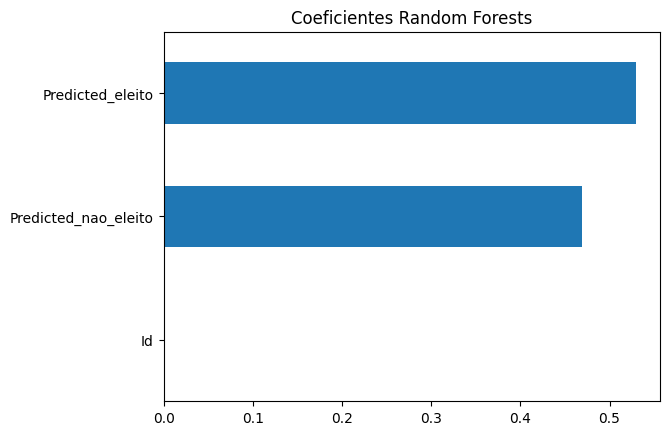

In [69]:
rf_coef =  pd.Series(mdl.feature_importances_, index=X_train.columns)
rf_imp_coef = pd.concat([rf_coef.sort_values().tail(5)])
rf_imp_coef.plot(kind = "barh")
plt.title("Coeficientes Random Forests")

#### Decision Tree

In [70]:
decision_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=42)

In [71]:
mean_absolute_error(y_test, predict_ohe)

0.0

#### Acurácia da Árvore de Decisão

In [72]:
predict_tree = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predict_tree)
print('Acurácia da Árvore de Decisão: %.3f%%' % (accuracy * 100))

Acurácia da Árvore de Decisão: 100.000%


In [73]:
print(classification_report(y_test, predict_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



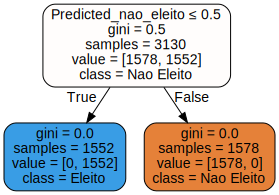

In [74]:
decision_tree_graph = tree.export_graphviz(decision_tree, out_file=None, 
                     feature_names=X_train.columns,
                     class_names=['Nao Eleito','Eleito'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(decision_tree_graph)  
graph

#### AdaBoost

In [75]:
decision_tree2 = DecisionTreeClassifier(max_depth=4, random_state=42)
ada_clf = AdaBoostClassifier(decision_tree2, n_estimators=200, learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                         random_state=42),
                   learning_rate=0.5, n_estimators=200)

#### Acurácia AdaBoost

In [76]:
predict_ada = ada_clf.predict(X_test)
accuracy = accuracy_score(y_test, predict_ada)
print('Acurácia AdaBoost: %.3f%%' % (accuracy * 100))

Acurácia AdaBoost: 100.000%


In [77]:
print(classification_report(y_test, predict_ada))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Text(0.5, 1.0, 'Coeficientes Adaboost')

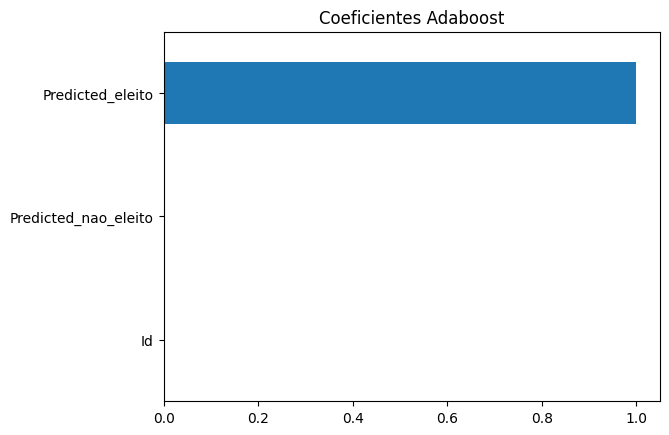

In [78]:
ab_coef =  pd.Series(ada_clf.feature_importances_, index=X_train.columns)
ab_imp_coef = pd.concat([ab_coef.sort_values().tail(5)])
ab_imp_coef.plot(kind = "barh")
plt.title("Coeficientes Adaboost")

#### Regressão Logística

Regressão Logística com AdaBoosta

In [79]:
lr_ada = LogisticRegression(random_state=42, max_iter=1000)
ada_clf2 = AdaBoostClassifier(lr_ada, n_estimators=200, learning_rate=0.5)
ada_clf2.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                     random_state=42),
                   learning_rate=0.5, n_estimators=200)

Acurácia Regressão Logística com AdaBoosta

In [80]:
predict_lr_ada = ada_clf2.predict(X_test)
accuracy = accuracy_score(y_test, predict_lr_ada)
print('Acurácia Regressão Logística: %.3f%%' % (accuracy * 100))

Acurácia Regressão Logística: 100.000%


In [81]:
print(classification_report(y_test, predict_lr_ada))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Regressão Logística sem AdaBoost

In [82]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Acurácia Regressão Logística

In [83]:
predict_lr = lr.predict(X_test)
accuracy = accuracy_score(y_test, predict_lr)
print('Acurácia Regressão Logística: %.3f%%' % (accuracy * 100))

Acurácia Regressão Logística: 100.000%


In [84]:
print(classification_report(y_test, predict_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Text(0.5, 1.0, 'Coeficientes Regressao Logística')

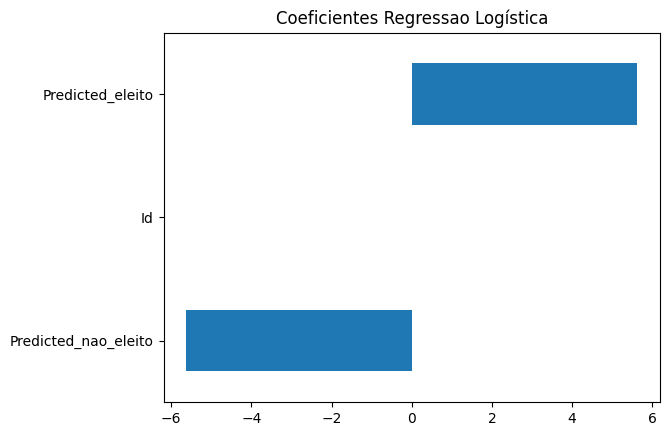

In [85]:
lr_coef =  pd.Series(lr.coef_[0], index=X_train.columns)
lr_imp_coef = pd.concat([lr_coef.sort_values().head(5)])
lr_imp_coef.plot(kind = "barh")
plt.title("Coeficientes Regressao Logística")

GradientBoost

In [86]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5, random_state=42)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=200, random_state=42)

Acurácia GradientBoost

In [87]:
predict_gb_clf = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test, predict_gb_clf)
print('Acurácia GradientBoost: %.3f%%' % (accuracy * 100))

Acurácia GradientBoost: 100.000%


In [88]:
print(classification_report(y_test, predict_gb_clf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Text(0.5, 1.0, 'Coeficientes Gradient Boosting')

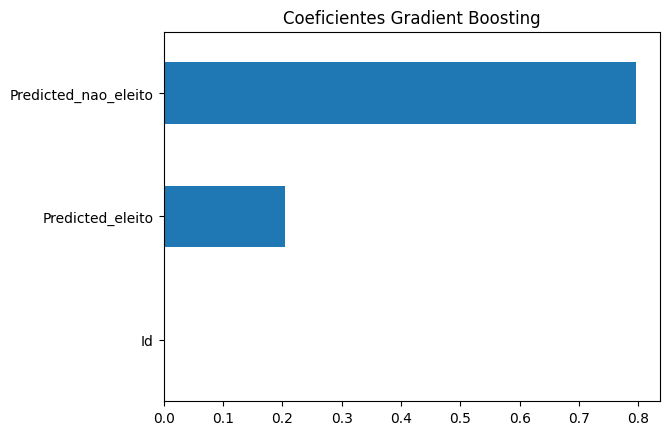

In [89]:
gb_coef =  pd.Series(gb_clf.feature_importances_, index=X_train.columns)
gb_imp_coef = pd.concat([gb_coef.sort_values().tail(5)])
gb_imp_coef.plot(kind = "barh")
plt.title("Coeficientes Gradient Boosting")

#### 5. Envie seus melhores modelos conforme resultados nos dados de teste. Sugestões para melhorar o modelo: (10 pts.)

    - 1. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
    - 2. Experimente balancear as classes,  caso estejam desbalanceadas.

In [90]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

In [91]:
predict_svm = svm.predict(X_test)
accuracy = accuracy_score(y_test, predict_svm)
print('Acurácia SVM: %.3f%%' % (accuracy * 100))

Acurácia SVM: 100.000%


In [92]:
print(classification_report(y_test, predict_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       270

    accuracy                           1.00       553
   macro avg       1.00      1.00      1.00       553
weighted avg       1.00      1.00      1.00       553



Text(0.5, 1.0, 'Coeficientes SVM')

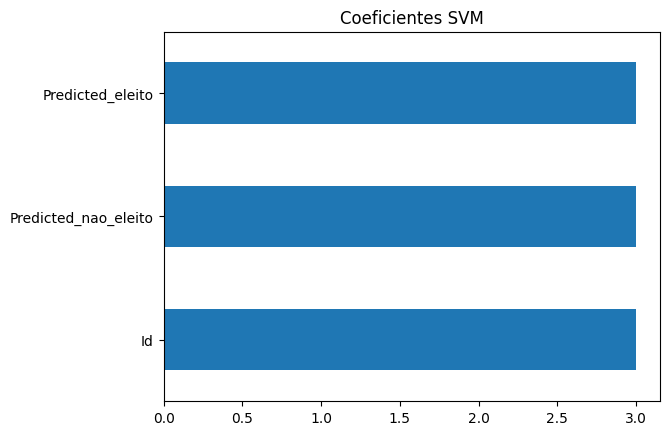

In [93]:
svm_coef =  pd.Series(svm.n_features_in_, index=X_train.columns)
svm_imp_coef = pd.concat([svm_coef.sort_values().tail(5)])
svm_imp_coef.plot(kind = "barh")
plt.title("Coeficientes SVM")